# Load the features and initialize the constants

In [107]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

import tensorflow as tf
#from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [93]:
# ---------------------------------------
# Read feature names
# ---------------------------------------

f = open("openface_feature_names.json", "r")
all_features = json.load(f)
f.close()

#Regex to link feature names to what they represent
feature_regex = {
    "action_units": ['AU'],
    "gaze": ['gaze'],
    "shape": ['p_'],
    "landmarks_2d": [' x_', ' y_'],
    "landmarks_3d": [' X_', ' Y_', ' Z_'],
    "eye_lmk_2d": ["lmk_x", "lmk_y"],
    "eye_lmk_3d": ["lmk_X", "lmk_Y", "lmk_Z"],
    "output": ["rating"]
}
features = defaultdict(list)
for feature, regexes in feature_regex.items():
    for col in all_features:
        for regex in regexes:
            if regex in col:
                features[feature].append(col)

#Features to use for training
training_features = ['action_units', 'shape', 'landmarks_2d', 'eye_lmk_2d']
training_features = [ftr_name for feature in training_features for ftr_name in features[feature]]

feature_indices = sorted([all_features.index(feature) for feature in training_features])

In [91]:
#Constants
FEATURE_INDICES = feature_indices
MAX_FRAMES_PER_VIDEO = 800 #Pad/Truncate data to maitain 800 frames
FEATURE_COUNT = len(FEATURE_INDICES)
print("Number of features used for training : ", FEATURE_COUNT)

Number of features used for training :  323


# Deep Learning

In [82]:
#Generator to load data in batches to avoid memory overflow

#Features and labels can be processed inside this generator
def gen(ftr_files):
    ftr_files = [file.decode() for file in ftr_files]
    for i, file in enumerate(ftr_files):
        #Ignore hidden files such as '.dstore'
        if '.npy' not in file:
            continue
        try: #If any issues with reading the current file or missing label, ignore the video
            ftrs = np.load(f'visual_features/{file}')
            ftrs = ftrs[:, FEATURE_INDICES]
            v_id = file.split('.')[0]
            label = np.load(f'visual_labels/{file}')
        except:
            continue
        
        #Pad 0 valued frames(at the end) if frame count for the video lower than MAX_FRAMES_PER_VIDEO
        #Delete frames(from the front) if frame count grater than MAX_FRAMES_PER_VIDEO
        ftrs = tf.keras.preprocessing.sequence.pad_sequences([ftrs], maxlen=MAX_FRAMES_PER_VIDEO, 
                                                             dtype='float64', padding='post', 
                                                             truncating='pre', value=0.0)
        yield ftrs[0], label

In [94]:
#Generate an LSTM
def generate_model(input_size, max_length):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.InputLayer(input_shape = (input_size, max_length)))
    
    rnn_layer = tf.keras.layers.LSTM(units = 20, activation = 'sigmoid', dropout = 0, recurrent_dropout = 0, implementation = 1, return_sequences = False)
    model.add(rnn_layer)
    
    dense_layer = tf.keras.layers.Dense(20)
    model.add(dense_layer)
    
    dense_layer = tf.keras.layers.Dense(1)
    model.add(dense_layer)
    
    model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2))
    model.build()
    model.summary()
    return model

In [95]:
#Create the train and test datasets
ftr_files = [file for file in os.listdir('visual_features/') if '.npy' in file]
np.random.shuffle(ftr_files)

#Keep x% of data as training
file_count = len(ftr_files)
train_size = 80 #In %age
split_index = (file_count*80)//100

train, test = ftr_files[:split_index], ftr_files[split_index:]

#Training dataset
dataset_train = tf.data.Dataset.from_generator(
     gen, (tf.float64, tf.float64),
     output_shapes=(tf.TensorShape((None, None)), tf.TensorShape(())), args=(train,))
dataset_train_batched = dataset_train.batch(128, drop_remainder=True)
dataset_train_batched_prefetched = dataset_train_batched.prefetch(1)

#Test dataset
dataset_test = tf.data.Dataset.from_generator(
     gen, (tf.float64, tf.float64),
     output_shapes=(tf.TensorShape((None, None)), tf.TensorShape(())), args=(test,))
dataset_test_batched = dataset_test.batch(1)
dataset_test_prefetched = dataset_test_batched.prefetch(1)

In [96]:
model = generate_model(MAX_FRAMES_PER_VIDEO, FEATURE_COUNT)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 20)                27520     
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 27,961
Trainable params: 27,961
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(dataset_train_batched_prefetched, epochs=100, validation_data=dataset_test_batched)#_prefetched)

Epoch 1/100
14/14 [==============================] - 50s 4s/step - loss: 154.2523 - val_loss: 48.7091
Epoch 2/100
14/14 [==============================] - 52s 4s/step - loss: 34.5535 - val_loss: 39.9486
Epoch 3/100
14/14 [==============================] - 49s 3s/step - loss: 32.0946 - val_loss: 29.0385
Epoch 4/100
14/14 [==============================] - 46s 3s/step - loss: 28.9406 - val_loss: 28.9143
Epoch 5/100
14/14 [==============================] - 48s 3s/step - loss: 28.2227 - val_loss: 29.1197
Epoch 6/100
14/14 [==============================] - 51s 4s/step - loss: 28.1768 - val_loss: 28.8463
Epoch 7/100
14/14 [==============================] - 52s 4s/step - loss: 28.1276 - val_loss: 28.8877
Epoch 8/100
14/14 [==============================] - 52s 4s/step - loss: 28.1364 - val_loss: 28.8633
Epoch 9/100
14/14 [==============================] - 50s 4s/step - loss: 28.1281 - val_loss: 28.8653
Epoch 10/100
14/14 [==============================] - 49s 4s/step - loss: 28.1327 - val_lo

14/14 [==============================] - 52s 4s/step - loss: 28.1976 - val_loss: 28.8755
Epoch 82/100
14/14 [==============================] - 51s 4s/step - loss: 28.1983 - val_loss: 28.8755
Epoch 83/100
14/14 [==============================] - 53s 4s/step - loss: 28.1990 - val_loss: 28.8755
Epoch 84/100
14/14 [==============================] - 51s 4s/step - loss: 28.1998 - val_loss: 28.8755
Epoch 85/100
14/14 [==============================] - 51s 4s/step - loss: 28.2005 - val_loss: 28.8755
Epoch 86/100
14/14 [==============================] - 49s 3s/step - loss: 28.2012 - val_loss: 28.8755
Epoch 87/100
14/14 [==============================] - 48s 3s/step - loss: 28.2019 - val_loss: 28.8755
Epoch 88/100
14/14 [==============================] - 54s 4s/step - loss: 28.2026 - val_loss: 28.8755
Epoch 89/100
14/14 [==============================] - 50s 4s/step - loss: 28.2033 - val_loss: 28.8755
Epoch 90/100
14/14 [==============================] - 49s 4s/step - loss: 28.2039 - val_loss: 2

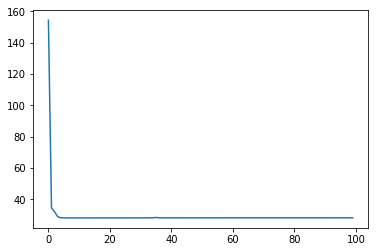

In [98]:
plt.plot(history.history['loss'])

(457,) (457,)


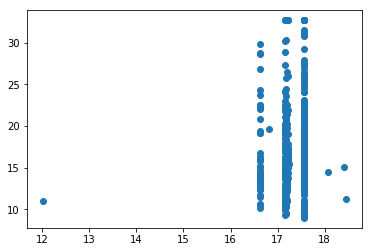

In [76]:
x_test = np.array([ele for batch in dataset_test_batched.as_numpy_iterator() for ele in batch[0]])
y_test = np.array([ele for batch in dataset_test_batched.as_numpy_iterator() for ele in batch[1]])
results = model.predict(x_test)
results = results.reshape(-1)
print(results.shape,y_test.shape)
plt.scatter(results, y_test)

In [81]:
print(results, y_test)

[17.562601 17.562601 17.191872 17.562601 17.562601 17.562601 16.626986
 17.1574   17.562601 16.626986 17.562601 17.227453 17.178532 16.626986
 17.227453 17.562601 16.626986 17.169424 17.562601 17.562601 17.204817
 17.562601 17.164083 17.562601 17.208838 17.162666 17.562601 17.166983
 17.562601 17.562601 17.16273  17.562601 17.169779 17.163225 17.562601
 17.562601 17.562601 17.155544 17.562601 17.562601 17.562601 17.562601
 17.562601 17.187971 16.626986 16.626986 17.171968 17.562601 17.16115
 17.15199  17.184404 17.188963 17.165762 17.16369  17.562601 17.15232
 17.562601 17.562601 17.16363  17.562601 17.562601 17.183458 17.180933
 17.562601 17.562601 17.227453 17.562601 17.562601 16.626986 17.227453
 17.186228 18.066092 17.562601 17.562601 17.562601 16.626986 17.562601
 17.562601 16.626986 17.167887 17.562601 17.562601 17.163313 17.170986
 17.206907 17.562601 17.562601 17.562601 16.626986 17.562601 17.166933
 17.184433 17.164667 17.165201 17.562601 17.165178 17.174171 17.160416
 17.1881

In [80]:
tf.keras.losses.MSE(y_test, results)

<tf.Tensor: shape=(), dtype=float32, numpy=28.722319>

In [108]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
